In [64]:
# importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


In [7]:
# train and test data files are provided as separate csv files

train = pd.read_csv('datasets/train_cleaned.csv')
test = pd.read_csv('datasets/test_cleaned.csv')

For the initial linear regression model that did not yield the best results, I engaged in feature engineering and selected 11-13 features to model on, driven by a desire to avoid overfitting my model.

Intuitively, some feautres such as garage condition and quality or fireplace condition and quality may be related to each other, so I wanted to create an interaction term that captured the relationship and use that in the model to avoid overfitting.

In [8]:
# Identified below that 'garage_cond' and 'garage_qual' have a 0.95 correlation with each other...
# so create interaction term below
z = train[['garage_cond', 'garage_qual']]
print(z.corr())

             garage_cond  garage_qual
garage_cond     1.000000     0.516762
garage_qual     0.516762     1.000000


In [9]:
# creating interaction term for the train dataset
train['garage_interaction'] = train['garage_cond'] * train['garage_qual']
# creating interaction term for the test dataset
test['garage_interaction'] = test['garage_cond'] * test['garage_qual']

In [10]:
k = train[['garage_area', 'garage_cars']]
k.corr()


,garage_area,garage_cars
garage_area,1.000000,0.897083
garage_cars,0.897083,1.000000


In [11]:
train['garage_size_interaction'] = train['garage_area'] * train['garage_cars']
test['garage_size_interaction'] = test['garage_area'] * test['garage_cars']

### Setting X & Y variables for Linear Regression Model

In [18]:
train.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

In [22]:
X = train[['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual',
'garage_size_interaction', 'full_bath', '1st_flr_sf', 'total_bsmt_sf', 'age']] 

y = train['saleprice']

### Check to ensure that there are no null values in our features otherwise our model may have problems

In [23]:
X.isnull().sum()

overall_qual               0
exter_qual                 0
gr_liv_area                0
kitchen_qual               0
garage_size_interaction    0
full_bath                  0
1st_flr_sf                 0
total_bsmt_sf              0
age                        0
dtype: int64

### Time to model our data!

First we will begin by performing a train test split and instantiating our linear regression model. Since we already have a 'test' dataset, I will call my test split the "holdout" dataset instead.

In [24]:
# performing train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 42)

In [25]:
lr = LinearRegression()

In [27]:
lr.fit(X_train, y_train)

print(f'The accuracy score on our trainig set is: {lr.score(X_train, y_train)}')
print(f'The accuracy score on our holdout set is: {lr.score(X_holdout, y_holdout)}')

The accuracy score on our trainig set is: 0.8516463762070873
The accuracy score on our holdout set is: 0.8351860191374115


Generate predictions using our X_holdout set. And then calculate the residuals equal to the difference between our predicted y and the y_holdout.

In [28]:
predictions_lr = lr.predict(X_holdout)

In [29]:
residuals_lr = y_holdout - predictions_lr

## Calculate the Root Mean Squared Error of our predictions--lower the better

In [30]:
np.sqrt(mean_squared_error(y_holdout, predictions_lr))

30093.06030501517

Plot of our residuals below shows there are a couple outliers--opportunities for improvement to be addressed in our next notebook (#3)

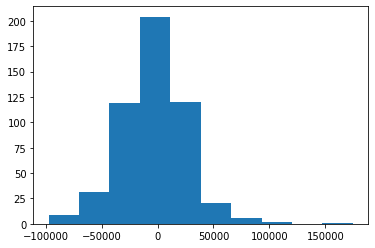

In [31]:
plt.hist(residuals_lr);

RMSE is not the only metric by which we can evaluate our model. Several metrics are built in to sklearn that can be used and we can build a function to efficiently obtain these different results.

In [62]:
def model_metrics(target, predictions):
    # function requires the following libraries/packages to be imported:
    # from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    # returns R-squared:
    print(f'The R-squared of the model is: \
    {round(r2_score(target, predictions), 4)}.')
    # returns MAE
    print(f'The mean absolute error (MAE) of the model is: {round(mean_absolute_error(target, predictions), 4)}.')
    # returns MSE
    print(f'The mean squared error (MSE) of the model is : {round(mean_squared_error(target, predictions), 4)}.')
    # returns RMSE
    print(f'The root mean squared error (RMSE) of the model is: {round(np.sqrt(mean_squared_error(target, predictions)), 4)}.')
    

In [63]:
model_metrics(y_holdout, predictions_lr)

The R-squared of the model is:     0.8352.
The mean absolute error (MAE) of the model is: 22527.1782.
The mean squared error (MSE) of the model is : 905592278.5213.
The root mean squared error (RMSE) of the model is: 30093.0603.


The code below will return a data frame listing the coefficients of each of the features in our regression model. These are easily interpretable and can be evaluated for impact on our target variable.

For example, we can interpret the coefficient for 'overall_qual' as follows: "For a one unit increase in the value of home's overall quality, we expect sale price to increase by approximately $13,181.99, holding all else constant."

Or, for a one unit (one year) increase in the age of a home, we can expect the sale price to decrease by approximately $226.81, holding all else constant.

In [34]:
lr_coef = pd.DataFrame(lr.coef_, index=X.columns)
lr_coef

,0
overall_qual,13181.992162
exter_qual,19334.396642
gr_liv_area,55.498547
kitchen_qual,12615.910528
garage_size_interaction,14.754570
full_bath,-10275.039910
1st_flr_sf,14.748285
total_bsmt_sf,30.638309
age,-226.808246


While these coefficients are easily interpretable, they do not reveal the relative importance of each feature in the model, as it is not necessarily reasonable to compare these coefficients directly--they all have different units, for example the quality features are measured on a scale of 1-10, while area measures are in number of square feet and bedrooms and bathrooms are represented in units.